# DE data analysis

I still feel the need to have a notebook storing all the data analysis. 

In [26]:
from deLib import de_data
import pandas as pd
import os
import matplotlib.pyplot as plt
from myImageLib import bestcolor, gauss1, readdata
import numpy as np
from scipy.optimize import curve_fit
import trackpy as tp
from matplotlib.patches import Ellipse
from corrLib import autocorr1d
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d
from matplotlib import colors, cm

## 0 Parameter space

In [2]:
# load log file
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
dd = de_data(log)

In [3]:
# filter out Chile data
log1 = log.loc[(log.Comment!="Chile")&(log.OD<80)&(log.OD>20)]
dd = de_data(log1)

In [4]:
# new data since 05312022
log_new = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"), sheet_name="05312022-")

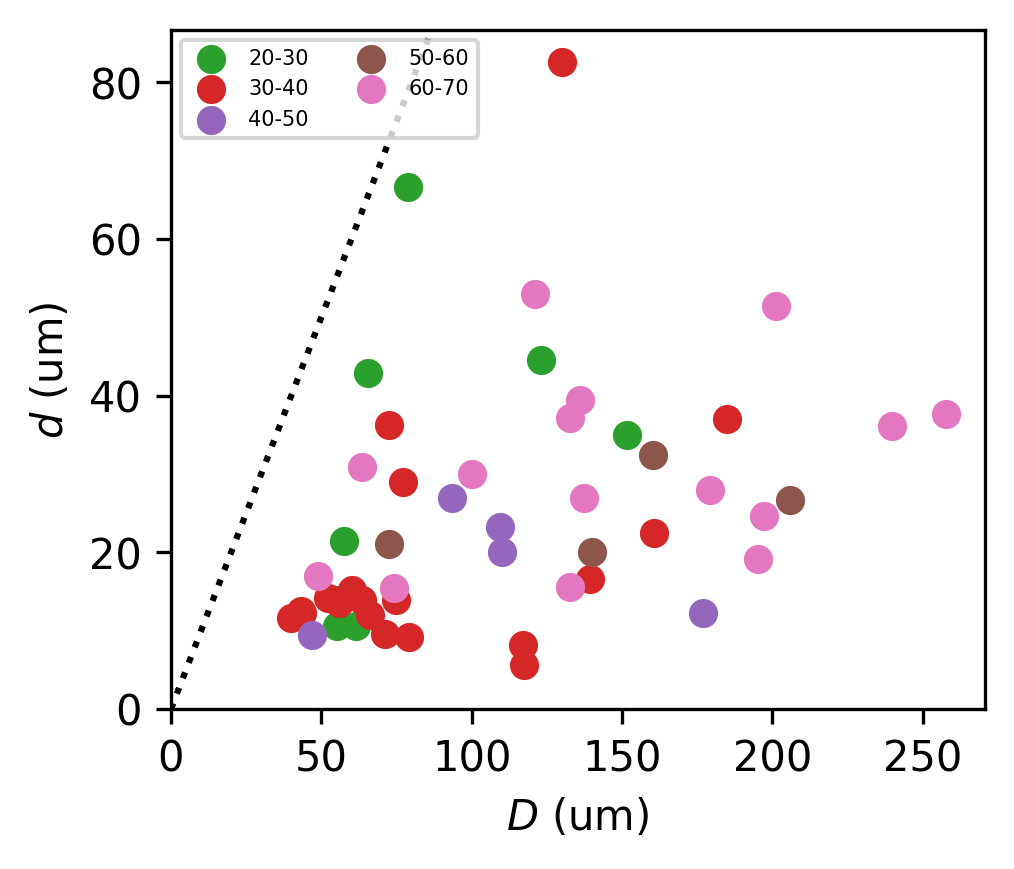

In [5]:
dd.parameter_space()
# plt.scatter(log_new.D, log_new.d, marker="^", edgecolor=bestcolor(1), facecolor=(0,0,0,0))

In [225]:
log1

,Date,Video#,DE#,OD,D,D_err,d,d_err,MPP,FPS,...,Rinfy,t2,(D-d)/d^2,D-d,d^3/(D-d),t2_fit,DA_fit,(D-d)/d,DA/OD,c
0,2021-08-12,0,5.0,23.0,90.20000,NaN,35.50000,NaN,0.10,30.0,...,0.25,4.7,0.043404,54.70000,817.895338,3.108841,0.046481,1.540845,0.002021,0.043484
1,2021-08-13,0,13.0,24.0,102.00000,NaN,36.80000,NaN,0.10,30.0,...,1.00,5.6,0.048145,65.20000,764.356319,6.870413,0.099792,1.771739,0.004158,0.090293
2,2021-08-13,1,14.0,24.0,80.00000,NaN,30.30000,NaN,0.10,30.0,...,1.00,4.3,0.054134,49.70000,559.720865,2.458447,0.236636,1.640264,0.009860,0.093300
3,2021-08-13,2,15.0,24.0,80.50000,NaN,25.70000,NaN,0.10,30.0,...,1.70,7.0,0.082969,54.80000,309.755347,4.633875,0.208424,2.132296,0.008684,0.120959
4,2021-08-13,3,19.0,24.0,91.10000,NaN,30.50000,NaN,0.10,30.0,...,1.40,7.0,0.065144,60.60000,468.195132,6.384190,0.140664,1.986885,0.005861,0.087106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2022-06-02,8,190.0,34.0,74.90835,NaN,13.91280,NaN,0.33,50.0,...,NaN,NaN,0.315115,60.99555,44.151501,5.021227,2.621069,4.384132,0.077090,0.284992
149,2022-06-03,0,191.0,26.0,61.40310,NaN,10.61082,NaN,0.33,50.0,...,NaN,NaN,0.451128,50.79228,23.520640,12.612847,0.661408,4.786838,0.025439,0.351072
150,2022-06-03,1,192.0,26.0,65.68518,NaN,42.88515,NaN,0.33,50.0,...,NaN,NaN,0.012397,22.80003,3459.277339,NaN,NaN,0.531653,NaN,0.326165
151,2022-06-03,2,193.0,26.0,55.12122,NaN,10.61082,NaN,0.33,50.0,...,NaN,NaN,0.395333,44.51040,26.840175,7.222361,0.530322,4.194812,0.020397,0.203264


Previously, I recklessly plot all the $\tau^*$ and $R_\infty$ data as functions of $D$ and $d$. If both $D$ and $d$ play a role in the dynamics, the plot can be noisy and extracting a trend will be very tricky. 

Here, using the limited data, I fix two parameters out of three ($OD$, $D$ and $d$) and plot $\tau^*$ and $R_\infty$ against the other one. This can hopefully reveal some trends which we can extract meaningful information. 

## 1 Fix $D$ and plot $d$

### 1.1 $OD \in [60, 80]$, $D \in [100, 150]$

It could be interesting to plot similar data in two panels: one being $R_\infty^2$ and the other being $R_\infty$. The current subset shows that $R_\infty$ follows $\tau^*$ better.

In [4]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD>=60)&(log.OD<=80)&(log.D>=100)&(log.D<=150)]

Text(0, 0.9, '$OD\\in[60, 80],D\\in[100, 150]$')

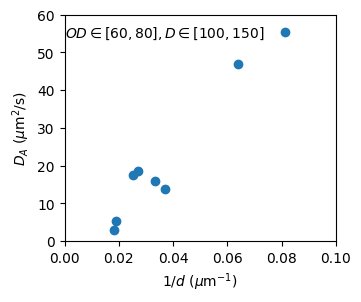

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
ax.scatter(1/log1.d, log1.DA_fit)
ax.set_xlabel("$1/d$ ($\mu$m$^{-1}$)")
ax.set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax.set_xlim([0, 0.1])
ax.set_ylim([0, 60])
ax.annotate("$OD\in[60, 80],D\in[100, 150]$", (0, 0.9), xycoords="axes fraction", horizontalalignment="left")

(0.0, 33.20391543176798)

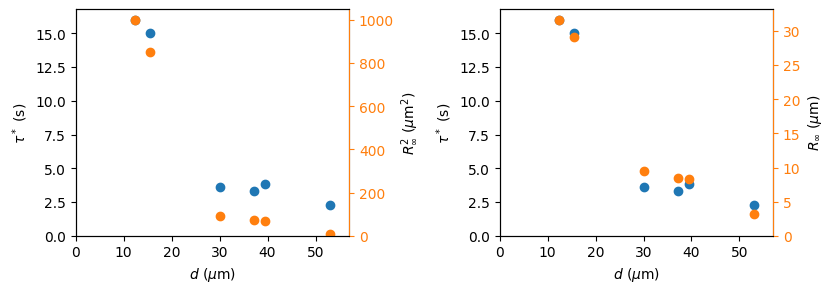

In [110]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,3), dpi=100, gridspec_kw={"wspace": 0.55})
# R_infty^2
ax[0].scatter(log1.d, log1.t2)
ax[0].set_ylabel("$\\tau^*$ (s)")
ax[0].set_xlabel("$d$ ($\mu$m)")
ax[0].set_xlim([0, log1.d.max()*1.05])
ax[0].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[0].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy, color=bestcolor(1))
ax1.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")
ax1.set_ylim([0, log1.Rinfy.max()*1.05])
# R_infty
ax[1].scatter(log1.d, log1.t2)
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].set_xlabel("$d$ ($\mu$m)")
ax[1].set_xlim([0, log1.d.max()*1.05])
ax[1].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[1].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy**0.5, color=bestcolor(1))
ax1.set_ylabel("$R_\infty$ ($\mu$m)")
ax1.set_ylim([0, log1.Rinfy.max()**0.5*1.05])

### 1.2 $OD \in [60, 80]$, $D \in [170, 220]$

In [111]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD>=60)&(log.OD<=80)&(log.D>=170)&(log.D<=220)]

(0.0, 28.946502379389468)

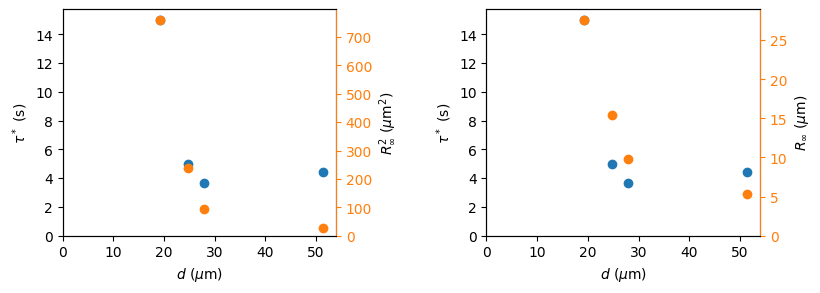

In [112]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,3), dpi=100, gridspec_kw={"wspace": 0.55})
# R_infty^2
ax[0].scatter(log1.d, log1.t2)
ax[0].set_ylabel("$\\tau^*$ (s)")
ax[0].set_xlabel("$d$ ($\mu$m)")
ax[0].set_xlim([0, log1.d.max()*1.05])
ax[0].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[0].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy, color=bestcolor(1))
ax1.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")
ax1.set_ylim([0, log1.Rinfy.max()*1.05])
# R_infty
ax[1].scatter(log1.d, log1.t2)
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].set_xlabel("$d$ ($\mu$m)")
ax[1].set_xlim([0, log1.d.max()*1.05])
ax[1].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[1].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy**0.5, color=bestcolor(1))
ax1.set_ylabel("$R_\infty$ ($\mu$m)")
ax1.set_ylim([0, log1.Rinfy.max()**0.5*1.05])

### 1.3 $OD \in [40, 60]$, $D \in [80, 120]$

In [95]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD>=40)&(log.OD<=60)&(log.D>=80)&(log.D<=120)]

(0.0, 8.784930278607794)

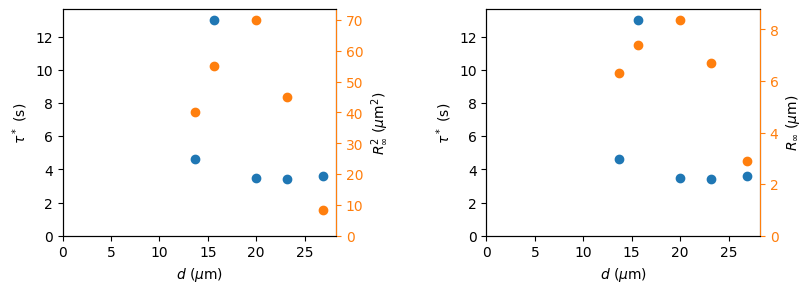

In [96]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,3), dpi=100, gridspec_kw={"wspace": 0.55})
# R_infty^2
ax[0].scatter(log1.d, log1.t2)
ax[0].set_ylabel("$\\tau^*$ (s)")
ax[0].set_xlabel("$d$ ($\mu$m)")
ax[0].set_xlim([0, log1.d.max()*1.05])
ax[0].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[0].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy, color=bestcolor(1))
ax1.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")
ax1.set_ylim([0, log1.Rinfy.max()*1.05])
# R_infty
ax[1].scatter(log1.d, log1.t2)
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].set_xlabel("$d$ ($\mu$m)")
ax[1].set_xlim([0, log1.d.max()*1.05])
ax[1].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[1].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy**0.5, color=bestcolor(1))
ax1.set_ylabel("$R_\infty$ ($\mu$m)")
ax1.set_ylim([0, log1.Rinfy.max()**0.5*1.05])

### 1.4 $OD \in [20, 40]$, $D \in [60, 100]$

In [68]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD>=20)&(log.OD<=40)&(log.D>=60)&(log.D<=100)]

(0.0, 5.556077753235641)

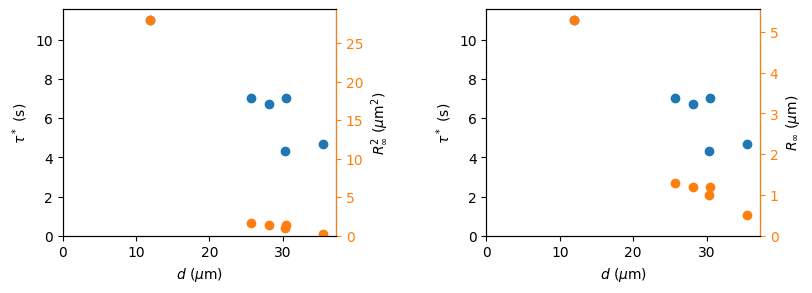

In [69]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,3), dpi=100, gridspec_kw={"wspace": 0.55})
# R_infty^2
ax[0].scatter(log1.d, log1.t2)
ax[0].set_ylabel("$\\tau^*$ (s)")
ax[0].set_xlabel("$d$ ($\mu$m)")
ax[0].set_xlim([0, log1.d.max()*1.05])
ax[0].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[0].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy, color=bestcolor(1))
ax1.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")
ax1.set_ylim([0, log1.Rinfy.max()*1.05])
# R_infty
ax[1].scatter(log1.d, log1.t2)
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].set_xlabel("$d$ ($\mu$m)")
ax[1].set_xlim([0, log1.d.max()*1.05])
ax[1].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[1].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy**0.5, color=bestcolor(1))
ax1.set_ylabel("$R_\infty$ ($\mu$m)")
ax1.set_ylim([0, log1.Rinfy.max()**0.5*1.05])

### 1.5 $OD \in [80, 100]$, $D \in [170, 270]$

In [113]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD>=80)&(log.OD<=100)&(log.D>=170)&(log.D<=270)]

(0.0, 46.95742752749559)

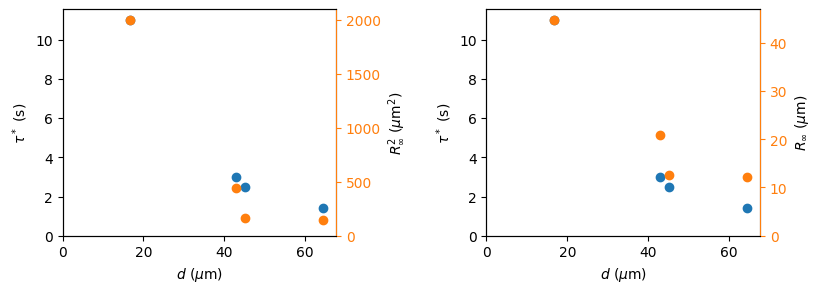

In [114]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,3), dpi=100, gridspec_kw={"wspace": 0.55})
# R_infty^2
ax[0].scatter(log1.d, log1.t2)
ax[0].set_ylabel("$\\tau^*$ (s)")
ax[0].set_xlabel("$d$ ($\mu$m)")
ax[0].set_xlim([0, log1.d.max()*1.05])
ax[0].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[0].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy, color=bestcolor(1))
ax1.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")
ax1.set_ylim([0, log1.Rinfy.max()*1.05])
# R_infty
ax[1].scatter(log1.d, log1.t2)
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].set_xlabel("$d$ ($\mu$m)")
ax[1].set_xlim([0, log1.d.max()*1.05])
ax[1].set_ylim([0, log1.t2.max()*1.05])
ax1 = ax[1].twinx()
ax1.spines["right"].set_color(bestcolor(1))
ax1.tick_params(axis='y', colors=bestcolor(1))
ax1.scatter(log1.d, log1.Rinfy**0.5, color=bestcolor(1))
ax1.set_ylabel("$R_\infty$ ($\mu$m)")
ax1.set_ylim([0, log1.Rinfy.max()**0.5*1.05])

Text(0, 0.5, '$R_\\infty^2$ ($\\mu$m$^2$)')

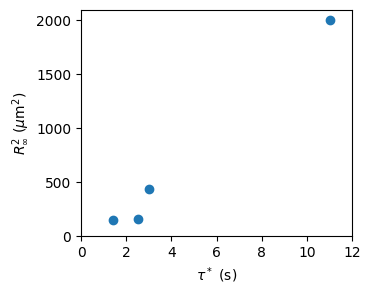

In [119]:
fig, ax = plt.subplots(figsize=(3.5,3), dpi=100)
ax.scatter(log1.t2, log1.Rinfy)
ax.set_xlim([0, 12])
ax.set_ylim([0, 2100])
ax.set_xlabel("$\\tau^*$ (s)")
ax.set_ylabel("$R_\infty^2$ ($\mu$m$^2$)")

### 1.6 Remarks

For $OD>60$, we identify a correlation between $R_\infty$ and $\tau^*$. In particular, the data in Sec 1.5 ($OD \in [80, 100]$, $D \in [170, 270]$) show that $R_\infty^2 \propto \tau^*$, as can be seen in the $R_\infty^2$ vs. $\tau^*$ plot above. **This slope of this linear relation reflects the strength of "active noise" in the system**, i.e. $D_A$ in the Langevin model. This can be seen from the MSD value in the $t\to\infty$ limit:
$$
\lim_{t\to\infty} \left< \Delta y^2(t) \right> = R_\infty^2 = \frac{2D_A\tau^*}{1+\tau/\tau^*}
$$
where $\tau^*:=1/\mu k$ is the time scale at which MSD saturates (relaxation time of the fluctuation). In our experiments, we typically have $\tau^*\gg\tau$, so that the denominator $1+\tau/\tau^*\approx 1$. As such, the long time MSD value can be further approximated as
$$
R_\infty^2 = 2D_A\tau^*
$$

While active noise shows intuitive dependence on bacterial concentration (Wu and Libchaber 2000) and bacterial activity (Maggi et al. 2014), whether it is an intrinsic property of an active bath remains an open question. For example, Patteson et al. 2016 showed that particle diffusivity in active bath depends on the particle size. Recent computational study by Ye et al. (2020) showed that the strength of active noise depends on external potential, and is therefore not an intrinsic property of an active bath. 

Here, experimentally, we can access the active noise by measuring the fluctuations of a small oil droplet in active baths confined in a larger aqueous droplet. The outer droplet naturally imposes a harmonic-like potential, which can be adjusted by changing the size of outer droplet. $D_A$ is calculated by $R_\infty^2/\tau^*$, and $k$, the potential constant, is calculated by $$
k = \frac{m^*g}{R_{free}} = \frac{1}{3} \pi \Delta\rho g \frac{d^3}{D-d}
$$

We first plot $D_A=R_\infty^2/\tau^*$ as functions of geometrical parameters $d$, $D$ and $D-d$.

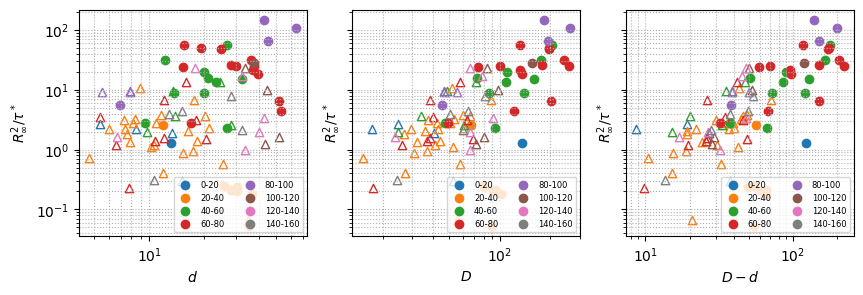

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), sharey=True, dpi=100)
dd.Rinf2_over_tau(x="d", ax=ax[0])
dd.Rinf2_over_tau(x="D", ax=ax[1])
dd.Rinf2_over_tau(x="D-d", ax=ax[2])

From the middle and the right panels above, the dependence of $D_A$ on the outer droplet diameter $D$, and free space $D-d$, is pronounced. As outer droplet gets larger, the active noise of the same active bath (same concentration of bacteria) gets stronger. **Presumably, the increase of $D_A$ with $D-d$ should saturate at very large $D$, at the $D_A$ value near a flat surface.** Such saturation being not pronounced in our data, suggests that more careful measurements are needed from experiment. 

In order to compare with the computational study by Ye et al., we also plot $D_A$ as a function of $k$. Their simulation results suggest that in both low and high concentration ($\rho=0.06$ or $0.3$), $D_A$ increases with the harmonic constant. Such an increase and then saturate trend, however, is not observed in our data.

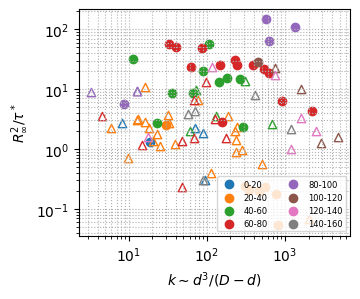

In [7]:
dd.Rinf2_over_tau(x="d^3/(D-d)", xlabel="k\sim d^3/(D-d)")

## 2 Unambiguous measurement of $R_\infty$ and $\tau^*$

Previously, I use hand fitting to roughly measure the saturation time $\tau^*$ and displacement $R_\infty$ of inner droplet MSD. While this technique allow quick data extraction, the measurement is ambiguous and inaccurate for a careful data analysis. Therefore, I now use real curve fitting to extract these values. I use the formula from Maggi et al. 2014 for the first test
$$
\left< \Delta y^2(t) \right> = \frac{2D_A}{\mu k} \frac{1-e^{-\mu kt} - \mu k\tau(1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$
To make the two time scales more apparent, let $\mu k = 1/\tau^*$ :
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

### 2.1 Fit with $D_A$, $\tau$ and $\tau^*$

In [11]:
def msd_model(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return dy2

In [9]:
# try to fit log data
def msd_model_log(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

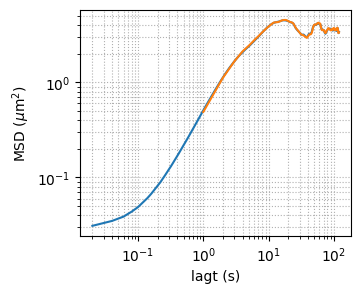

In [7]:
i = 175
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
msd = msd.dropna()
plt.figure(figsize=(3.5, 3), dpi=100)
plt.plot(msd.lagt, msd["<y^2>"])

trajo = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}o.csv".format(i)))
msdo = tp.msd(trajo, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
msdo = msdo.dropna()

plt.plot(msdo.lagt, msdo["<y^2>"])
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

[3.79524934e-01 4.70345768e-03 4.83618826e+00]


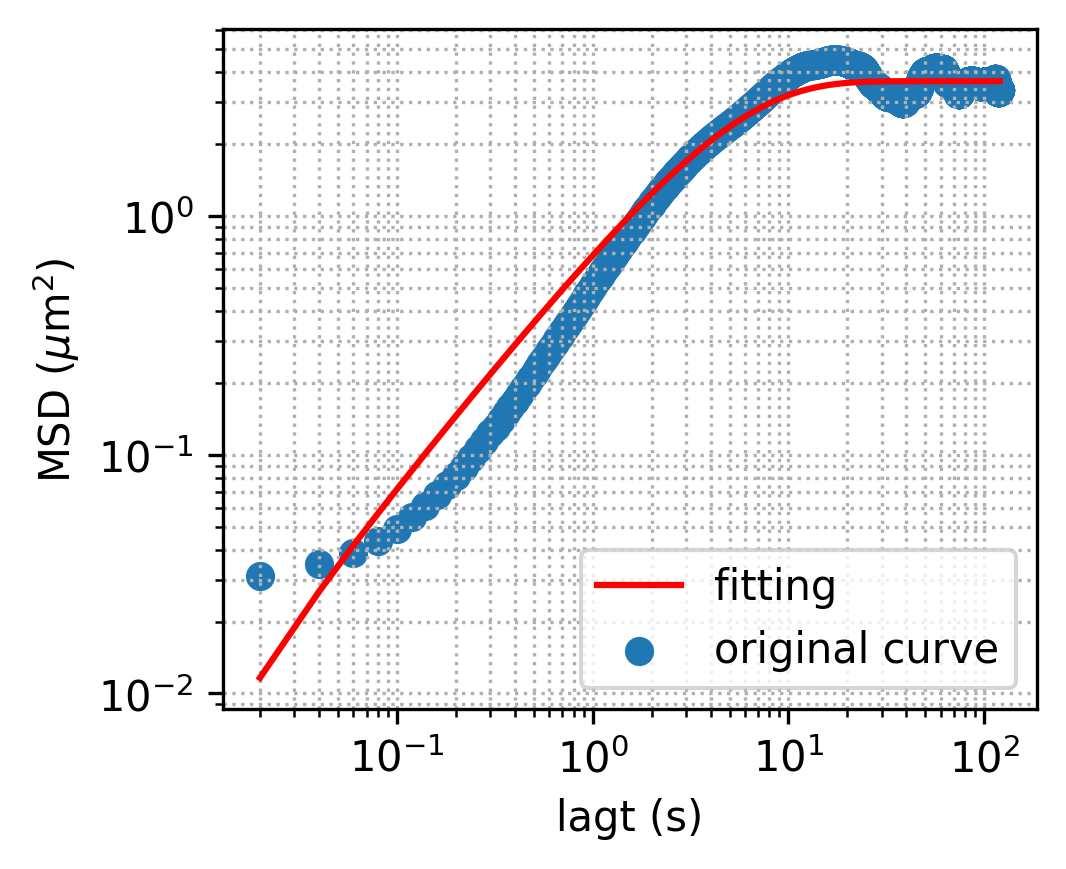

In [12]:
# Fit the curve with msd_model
popt, pcov = curve_fit(msd_model_log, msd.lagt, np.log(msd["<y^2>"]), p0=[1, 0.01, 10])
print(popt)
plt.figure(figsize=(3.5, 3), dpi=300)
plt.scatter(msd.lagt, msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

#### Aside: artificial traj with short time noise to reproduce the subdiffusive regime at short times

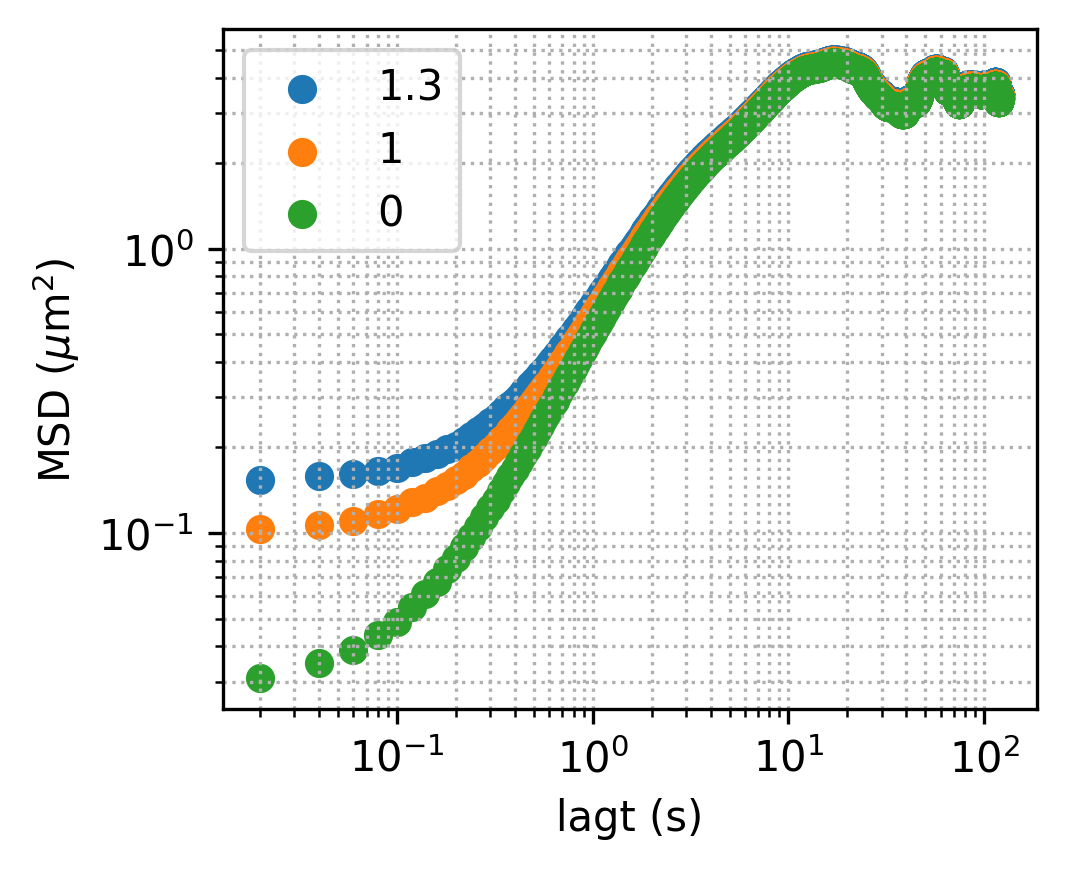

In [21]:
i = 175
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)

plt.figure(figsize=(3.5, 3), dpi=300)
for noise in [1.3, 1, 0]:
    t = traj.copy()
    t.x += (2 * np.random.rand(len(t)) - 1) * noise
    t.y += (2 * np.random.rand(len(t)) - 1) * noise
    msd = tp.msd(t, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
    msd = msd.dropna()
    plt.scatter(msd.lagt, msd["<y^2>"], label=noise)

plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")
plt.legend()

### 2.2 Fitting with $D_A$ and $\tau^*$, fix $\tau=0.15$ s

$\tau = 0.15$ s is a characteristic time scale of bacterial dynamics, estimated from the length of bacteria $l_b\approx 3$ $\mu$m and the swimming speed of bacteria $v_b\approx 20$ $\mu$m/s:
$$
\tau = \frac{l_b}{v_b} = 0.15 \:\text{s}
$$
We also assume that $t\gg\tau$, so that $e^{-t/\tau}\to 0$. This leads to a simplified model with only two fitting parameters $D_A$ and $\tau^*$: (keeping the $e^{-t/\tau}$ term leads to difficulty in fitting)
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*}{1-(\tau/\tau^*)^2}
$$

In [293]:
def msd_model_simp(lagt, DA, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    tau = 0.00
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star) / (1 - (tau/tau_star)**2)
    return dy2

D_A=5.21 um2/s, \tau^*=1.07 s


[]

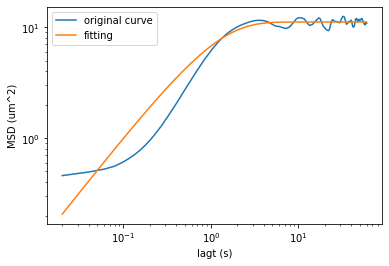

In [297]:
# Fit the curve with msd_model
i = 171
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=3000)
msd = msd.dropna()

popt, pcov = curve_fit(msd_model_simp, msd.lagt, msd["<y^2>"], p0=[10, 1], method="dogbox")
plt.plot(msd.lagt, msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model_simp(msd.lagt, *popt), label="fitting")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD (um^2)")
print("D_A={0:.2f} um2/s, \\tau^*={1:.2f} s".format(popt[0], popt[1]))

plt.loglog()

The fitting works pretty well, in particular the short time regime. This allows unambiguous extraction of $D_A$ and $\tau^*$. Note that the exact fitting parameter value depends on the choice of $\tau$. For example, when we choose $\tau=0.15$ s, we get $D_A=2.25$ um2/s, $\tau^*=2.23$ s; when we choose $\tau=0.2$ s, we get $D_A=2.35$ um2/s, $\tau^*=2.18$ s. Nonetheless, the results are reasonably close and can be regarded as the same within experimental error. From now on, unless otherwise noted, the fittings are all performed with $\tau=0.15$.

#### Short time MSD

In [ ]:
def ballistic_regime(t, DA, )

C:\Users\liuzy\AppData\Local\Temp/ipykernel_18976/247698600.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 1])
C:\Users\liuzy\AppData\Local\Temp/ipykernel_18976/247698600.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1])


(0.0015427911062860483, 1)

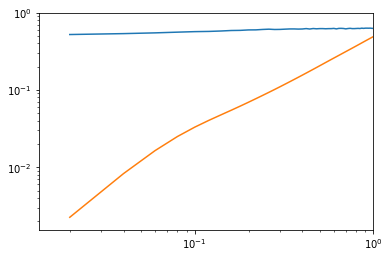

In [128]:
i = 175
logi = log.loc[log["DE#"]==i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).fillna(method="ffill")
# traj.x = gaussian_filter1d(traj.x, sigma=7/4)
traj.y = gaussian_filter1d(traj.y, sigma=7/4)
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=3000)
plt.plot(msd.lagt, msd["<x^2>"], label="original curve")
plt.plot(msd.lagt, msd["<y^2>"], label="original curve")
plt.loglog()
plt.xlim([0, 1])
plt.ylim([0, 1])

In [116]:
logt = np.log(msd.lagt)
logmsd = np.log(msd["<y^2>"])

(0.0, 2.0)

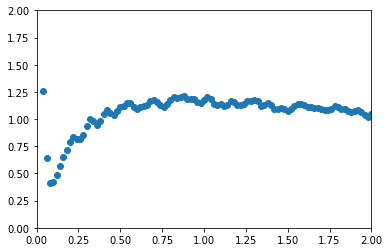

In [118]:
plt.scatter(logmsd.index/50, logmsd.diff(1)/logt.diff(1))
plt.xlim([0, 2])
plt.ylim([0, 2])

<BarContainer object of 30 artists>

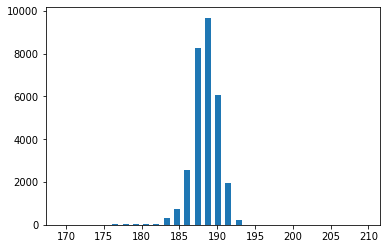

In [133]:
hist, bin_edges = np.histogram(traj.x, bins=30)
plt.bar(bin_edges[:-1], hist)

### 2.3 Fit all the MSD data and generate MSD fitting repo

Using the reduced model, we fit all the MSD curves and extract more accurate and unambiguous $D_A$ and $\tau^*$. To be able to check the fitting quality later, I save all the fitting plots in the MSD repo so I can come back at any time. 

<font color="red">The block below plots MSD fittings and save results as pictures in "Pictures" folder!</font>

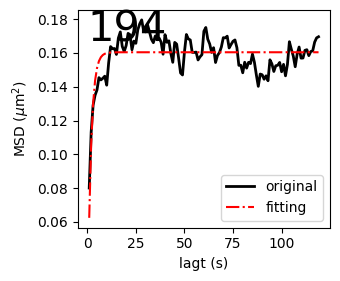

In [12]:
traj_folder = os.path.join(data_folder, "traj")
fig_folder = r"C:\Users\liuzy\Pictures"
log1 = log.loc[log.Comment!="Chile"]
count = 0
DE_list = [] # DE# list
DA_list = [] # container for fitted D_A values
tau_list = [] # container for fitted tau values
for num, i in log.iterrows():
    if i["DE#"] <= 160:
        continue
    if os.path.exists(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"]))) == False:
        continue
    traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"])))
    msd = tp.msd(traj, mpp=i.MPP, fps=i.FPS, max_lagtime=traj.frame.max()//5)
    msd = msd.dropna()
    popt, pcov = curve_fit(msd_model_simp, msd.lagt, msd["<y^2>"], p0=[1, 2], method="lm")
    DE_list.append(i["DE#"])
    DA_list.append(popt[0])
    tau_list.append(popt[1])
    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
    ax.plot(msd.lagt, msd["<y^2>"], color="black", lw=2, label="original")
    ax.plot(msd.lagt, msd_model_simp(msd.lagt, *popt), color="red", ls="-.",label="fitting")
    ax.legend(loc="lower right")
    ax.set_xlabel("lagt (s)")
    ax.set_ylabel("MSD ($\mu$m$^2$)")
    ax.annotate("{:d}".format(i["DE#"]), (.25, .8), xycoords="figure fraction", fontsize=30)
    plt.tight_layout()
    plt.pause(0.01)
    fig.savefig(os.path.join(fig_folder, "{:d}.jpg".format(i["DE#"])))
    clear_output(wait=True)
    plt.close()
    count += 1
    if count > 10000:
        break

In [13]:
data_tmp = pd.DataFrame({"DE#": DE_list, "DA_fit": DA_list, "tau_fit": tau_list})
data_tmp.to_csv("tmp_msddata_fit.csv")

### 2.4 Compare hand fitting and automatic fitting

Hand fitting and automatic fitting both characterize the plateau transition time and plateau value of MSD curves. Here, we compare the results from the two fitting techniques. In hand fitting, we get $\tau^*$ and $R_\infty$, while in automatic fitting, we get $\tau^*_{fit}$ and $D_A$. The following is expected:
$$
\tau^* \approx \tau^*_{fit} \\
R_\infty^2 / \tau^* \approx D_A
$$
The comparison is shown below:

In [6]:
# filter out Chile data
log1 = log.loc[log.Comment!="Chile"]

(0.0, 200.0)

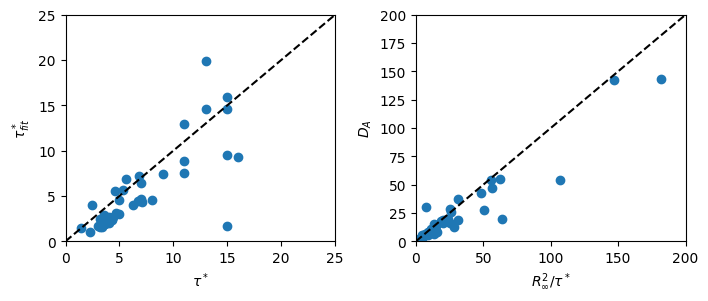

In [149]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), dpi=100, gridspec_kw={"wspace": 0.3})
# compare \tau^* and \tau^*_{fit}
ax[0].scatter(log1.t2, log1.t2_fit)
ax[0].plot([0, 25], [0, 25], color="black", ls="--")
ax[0].set_xlim([0, 25])
ax[0].set_ylim([0, 25])
ax[0].set_xlabel("$\\tau^*$")
ax[0].set_ylabel("$\\tau^*_{fit}$")
# compare R_\infty^2/\tau^* and D_A
ax[1].scatter(log1.Rinfy/log1.t2, log1.DA_fit)
ax[1].plot([0, 200], [0, 200], color="black", ls="--")
ax[1].set_xlabel("$R_\infty^2/\\tau^*$")
ax[1].set_ylabel("$D_A$")
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 200])

The two fitting techniques roughly give consistent results. However, a few outliers are identified and will be investigate in the next section. 

### 2.5 Look at the outliers

We first replot the comparison above and annotate DE# beside each data points.

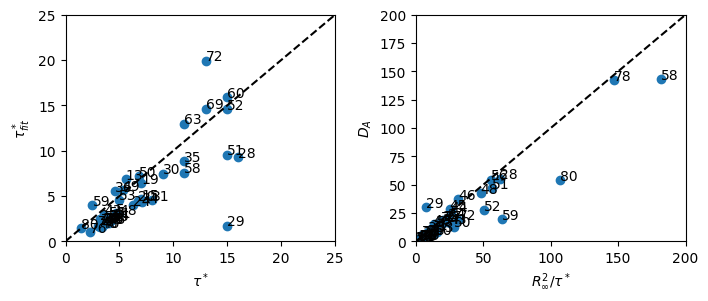

In [150]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), dpi=100, gridspec_kw={"wspace": 0.3})
# compare \tau^* and \tau^*_{fit}
ax[0].scatter(log1.t2, log1.t2_fit)
ax[0].plot([0, 25], [0, 25], color="black", ls="--")
ax[0].set_xlim([0, 25])
ax[0].set_ylim([0, 25])
ax[0].set_xlabel("$\\tau^*$")
ax[0].set_ylabel("$\\tau^*_{fit}$")
for num, i in log1.iterrows():
    ax[0].annotate(i["DE#"], (i.t2, i.t2_fit))
# compare R_\infty^2/\tau^* and D_A
ax[1].scatter(log1.Rinfy/log1.t2, log1.DA_fit)
ax[1].plot([0, 200], [0, 200], color="black", ls="--")
ax[1].set_xlabel("$R_\infty^2/\\tau^*$")
ax[1].set_ylabel("$D_A$")
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 200])
for num, i in log1.iterrows():
    ax[1].annotate(i["DE#"], (i.Rinfy/i.t2, i.DA_fit))

##### DE#29

In the left panel, the most outstanding outlier is DE#29. Let's look at its MSD and fitting in detail.

![](../images/2022/05/outlier1.png)

In the original MSD, since the displacement of DE#29 is much smaller than other ones in the same plot, the scale is quite small and therefore the linear diffusive regime is hard to identify. This leads to a big error when I tried to determine $\tau^*$ from the MSD collection plot. On the right, I show the automatic fitting result. The fitting looks good, since it captures both the plateau value and the transition time correctly. Hence, for this point, I trust the automatic fitting result, i.e. $\tau^*=1.7$ s. 

If we look at the $D_A$ vs. $R_\infty^2/\tau^*$ plot on the right, we find that DE#29 is also an outlier. However, if we use $\tau^*=1.7$ s, the automatic fitting result for the calculation of $R_\infty^2/\tau^*$, it turns out that $R_\infty^2/\tau^*\approx 58.8$ $\mu$m$^2$/s, within a factor of two difference with the fitted $D_A$ value $30$ $\mu$m$^2$/s. 

##### DE#72

DE#72 is also an outlier in the left panel. The original MSD curve and the fitting curve are shown below:

![](../images/2022/05/outlier2-72.png)

The MSD looks all fine, but due to the fact that inner droplet popped out during the video, the length of this trajectory is relatively short, resulting in the fitting curve to overestimate $\tau^*$.

Actually, if we increase the max lag time of MSD (from videolength/10 to videolength/5), the plateau regime of DE#72 MSD becomes more pronounced and the fitted $\tau^*$ gets smaller (9.9) and closer to the hand fitting $\tau^*$ (13):

![](../images/2022/05/longer-fitting-72.jpg)

Except DE#29 and DE#72, all other results from two fitting techniques remain close to each other and follow the same trend. Since the automatic fitting provides more accuracy and less ambiguity, we switch from now on the down stream analysis to automatic fitting. 

### 2.6 Try $D_A$ vs. $D-d$

We have seen the plot of $R_\infty^2/\tau^*$ vs. $D-d$, and saw an increasing trend roughly. Dispite the increasing trend, the data looks quite scattered, even on log-log scale. I suspect that the scattering is due to the inaccuracy of hand fitting of $R_\infty$ and $\tau^*$. That is the reason why I go for the model automatic fitting here. Supposedly, this fitting has better accuracy. Let's plot the equivalence of $R_\infty^2/\tau^*$ vs. $D-d$, i.e. $D_A$ vs. $D-d$, to verify this geometry-dependent active noise. 

We have already noticed that active noise depends strongly on $OD$. Therefore, this plot only include $OD\in[60, 80]$, in order to reveal a clear relationship.

Text(0, 0.5, '$D_A$ ($\\mu$m$^2$/s)')

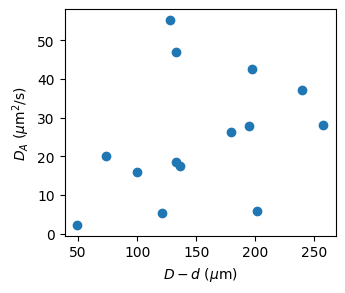

In [7]:
log2 = log1.loc[(log1.OD>=60)&(log1.OD<=80)]
log2 = log2.loc[~np.isnan(log2.t2)]
plt.figure(figsize=(3.5, 3), dpi=100)
plt.scatter(log2.D, log2.DA_fit)
# for num, i in log2.iterrows():
#     plt.annotate(i["d"], (i.D-i.d, i.DA_fit))
# plt.loglog()
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("$D_A$ ($\mu$m$^2$/s)")
# plt.xlim([0, 225])
# plt.ylim([0, 60])

This is again, more of scattered data than an increasing trend. To understand this data, we annotate the corresponding inner droplet diameter beside each data points:

![](../images/2022/05/DA_D-d.png)

The data show a segregation by inner droplet size $d$. For small $d$, $D_A$ is larger; for large $d$, $D_A$ is smaller. This is intuitive since we always observe that, when other conditions are fixed, smaller inner droplets show stronger fluctuations. If we look at a narrow range of $d$, say the *middle* range where $d\approx 25$ $\mu$m, we can fit a linear relation between $D_A$ and $D-d$. The slope $\approx 0.2$ $\mu$m/s is a velocity, while the physical significance is unclear. 

### 2.7 Fitting only the short time regime

The 3-parameter fitting in section 2.1 worked fine at long time limit. However, it does not provide an accurate account for the short time scale, where particle dynamics transition from ballistic to diffusive (theoretically). Here, we take closer look at the short time limit of MSD data (unsmoothed). Let's see if we can have more accurate fitting of $\tau$ by only fitting short time regime. 

The model we are going to fit data to is:
$$
\langle \Delta y^2 \rangle = \frac{D_A}{\tau(1+\tau/\tau^*)}t^2
$$
assuming $\tau^*\gg\tau$, 

## 3 Relaxation time $\tau^*$

The spring model predicts the relaxation time $\tau^*$ as:
$$
\tau^* = \frac{9\eta}{\Delta\rho g}\frac{D-d}{d^2}
$$
This should be the first thing to check after fitting MSD for $t_2$.

(0.0, 22.0)

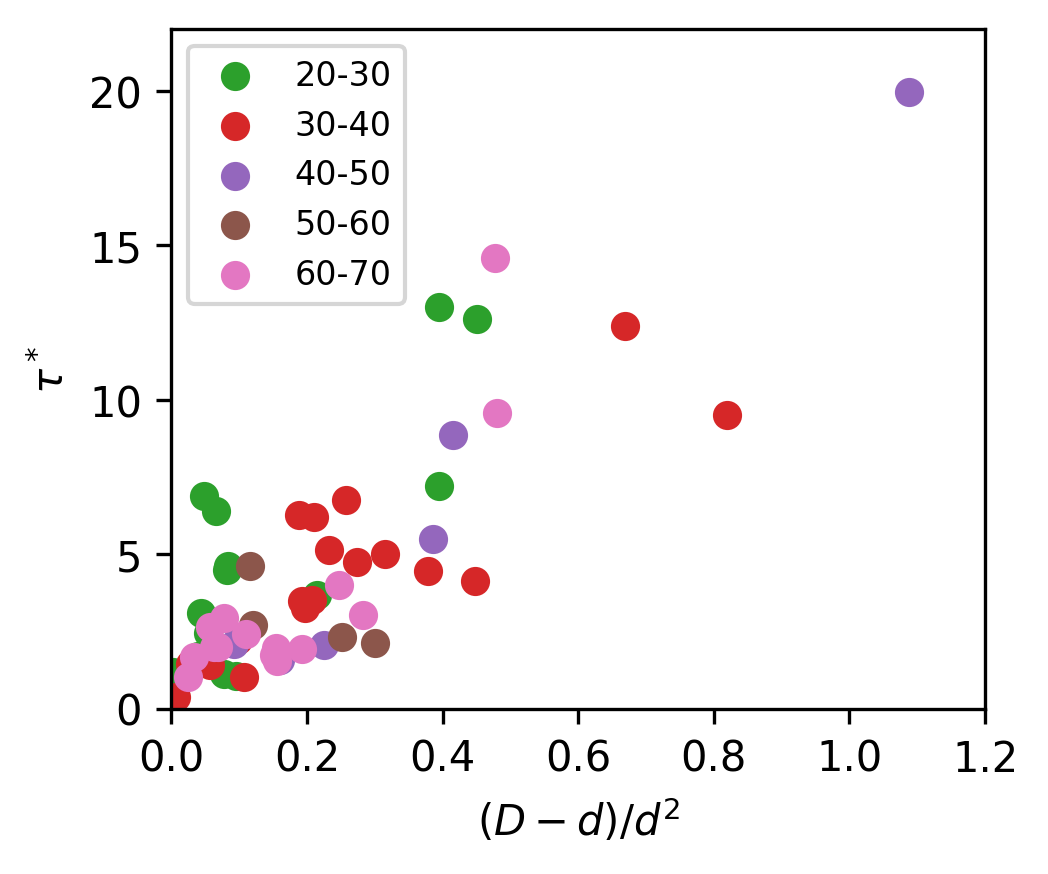

In [3]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)]
dd1 = de_data(log1)
dd1.scatter(x="(D-d)/d^2", y="t2_fit", xlabel="$(D-d)/d^2$", ylabel="$\\tau^*$", mode="lin")
plt.legend(loc="upper left", fontsize=8)
plt.xlim([0, 1.2])
plt.ylim([0, 22])

(0.0, 10.0)

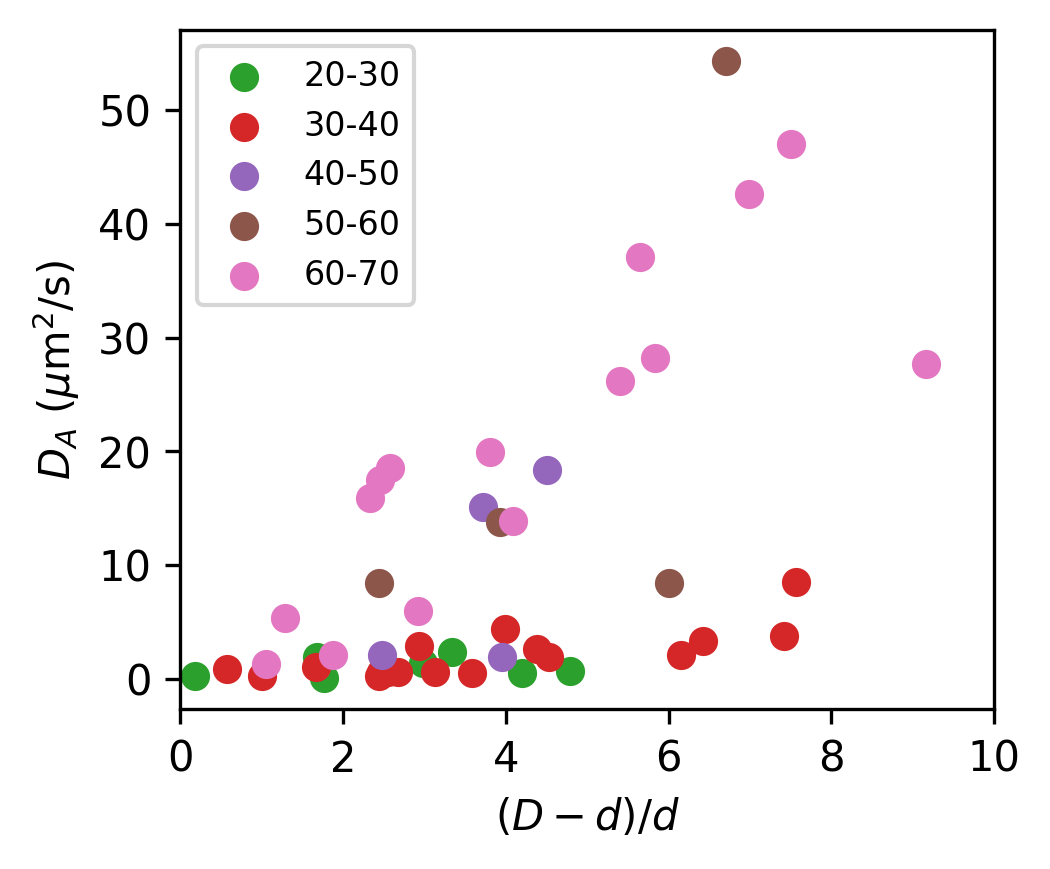

In [13]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)]
dd1 = de_data(log1)
dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="lin")
plt.legend(loc="upper left", fontsize=8)
plt.xlim([0, 10])

With new OD 20-40 data added, the linear relation becomes much more convincing.

The $\tau^*$ result above shows good linear dependence on $(D-d)/d^2$. This has inspired us to use theoretical $\tau^*$ as a given constant and fit for $\tau$ and $D_A$. <font color="blue">To be done</font>

## 4 1-D projection in a sphere

We use the solution of the Langevin equation in Maggi et al. 2014 (MSD) to fit our data. Although the fitting look okay, we need to stress a difference between our experimental geometries, being that their confinement is a cylinder and our confinement is a sphere, which can lead to different solutions. The following sketch shows the different geometries. 

![](../images/2022/05/sphere-cylinder-diff.png)

For their cylindrical system, the Langevin equation is written as 
$$
\mathbf{\dot r} = \mu \mathbf{f(r)} + \mathbf{\eta^A} + \mathbf{\eta^T},
$$
where $\mathbf{f(r)}=(0, -ky)$, basically no restoring force along the flat direction and an approximated spring force along the curved direction. Therefore, they can solve only the $y$-component equation to get $\langle \Delta y^2(t) \rangle$. The solution is the one we have always been using:
$$
\langle \Delta y^2(t) \rangle = \frac{2D_A}{\mu k}\frac{1-e^{-\mu k t} - \mu k\tau (1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$

We can also decompose the vectors in spherical coordinates:
$$
\dot r = \mu f(r) + \eta^A_r + \eta^T_r \\
r\dot\theta = \eta^A_\theta + \eta^T_\theta
$$

The r-component equation can be solved for $\langle \Delta r^2(t) \rangle$. But I'm not sure if I write the $\theta$-component equation right. 

For our spherical system, the original equation has to be modified. Specifically, the restoring force $\mathbf{f(r)}$ depends on both $x$ and $y$ position. Essentially, $\mathbf{f(r)}$ is now isotropic in $xy$-plane, formally $f(r) = kr$, so we can write the Langevin equation as:
$$
\dot r = -\mu k r + \eta^A + \eta^T
$$
where $r = \sqrt{x^2+y^2}$. 

We notice that this is almost identical to the $y$-component equation in the cylindrical system, <font color="red">except that the noise magnitude should be twice since we consider two spacial dimensions.</font> The solution is therefore identical in the form, except the prefactor:
$$
\langle \Delta r^2(t) \rangle = \frac{4D_A}{\mu k}\frac{1-e^{-\mu k t} - \mu k\tau (1-e^{-t/\tau})}{1-(\mu k\tau)^2}.
$$

What we observe with confocal is not $\langle \Delta r^2(t) \rangle$, but $\langle \Delta y^2(t) \rangle$. Due to the isotropic nature of the motion, we can connect $\langle \Delta r^2(t) \rangle$ and $\langle \Delta y^2(t) \rangle$ by:
$$
\Delta y(t) = \Delta r(t)\cos\theta,
$$
where $\theta$ is the angle between $\Delta r$ and $y$-axis. It follows:
$$
\langle \Delta y^2(t) \rangle = \langle \Delta r^2(t) \rangle \langle \cos^2\theta\rangle.
$$

Hence, $\langle \Delta y^2(t) \rangle$ and $\langle \Delta r^2(t) \rangle$ take exactly the same form, only has a difference in the prefactor $\langle \cos^2 \theta \rangle=\int_0^{2\pi}P(\theta)\cos^2\theta \,d\theta=\frac{1}{2}$. Interestingly, with this prefactor evaluated, we go back to exactly the same $\langle \Delta y^2(t) \rangle$ as in the cylindrical system. 

## 5 Rescaling $D_A$ data and outliers

In the May 12th meeting, we found a good collapse of $D_A$ data by normalizing $D-d$ with $d$ for the $OD\in[60, 80]$ bracket. I plot below the original $D_A$ vs. $D-d$ plot, along with the plot where $D-d$ is rescaled by $d$.

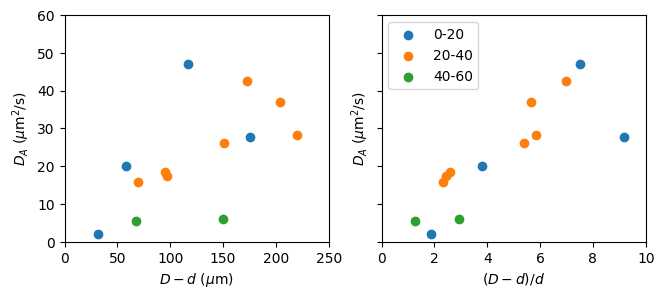

In [79]:
log2 = log1.loc[(log1.OD>=60)&(log1.OD<=80)]
log2 = log2.loc[~np.isnan(log2.t2)]
bounds = [[0, 20], [20, 40], [40, 60]]
colors = [bestcolor(0), bestcolor(1), bestcolor(2)]

fig, ax = plt.subplots(ncols=2, figsize=(7.5, 3), dpi=100, sharey=True)

for bound, color in zip(bounds, colors):
    log3 = log2.loc[(log2.d>=bound[0])&(log2.d<bound[1])]
    ax[0].scatter(log3.D - log3.d, log3.DA_fit, color=color)
ax[0].set_xlabel("$D-d$ ($\mu$m)")
ax[0].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[0].set_xlim([0, 250])
ax[0].set_ylim([0, 60])

for bound, color in zip(bounds, colors):
    log3 = log2.loc[(log2.d>=bound[0])&(log2.d<bound[1])]
    ax[1].scatter((log3.D - log3.d)/log3.d, log3.DA_fit, color=color, label="{0:d}-{1:d}".format(bound[0], bound[1]))
ax[1].set_xlabel("$(D-d)/d$")
ax[1].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 60])
ax[1].legend()

In the rescaled data, all the points follow a nice linear relation, except a blue point at (9, 25), corresponding to DE#52. Looking at the video (1103/06), the bacterial activity is indeed lower than expected. Therefore, it makes sense that the $D_A$ in this experiment deviates from the "normal" linear relation.

With this $OD$ bracket fixed, let's extend this rescaling to all the data and see how is the collapse.

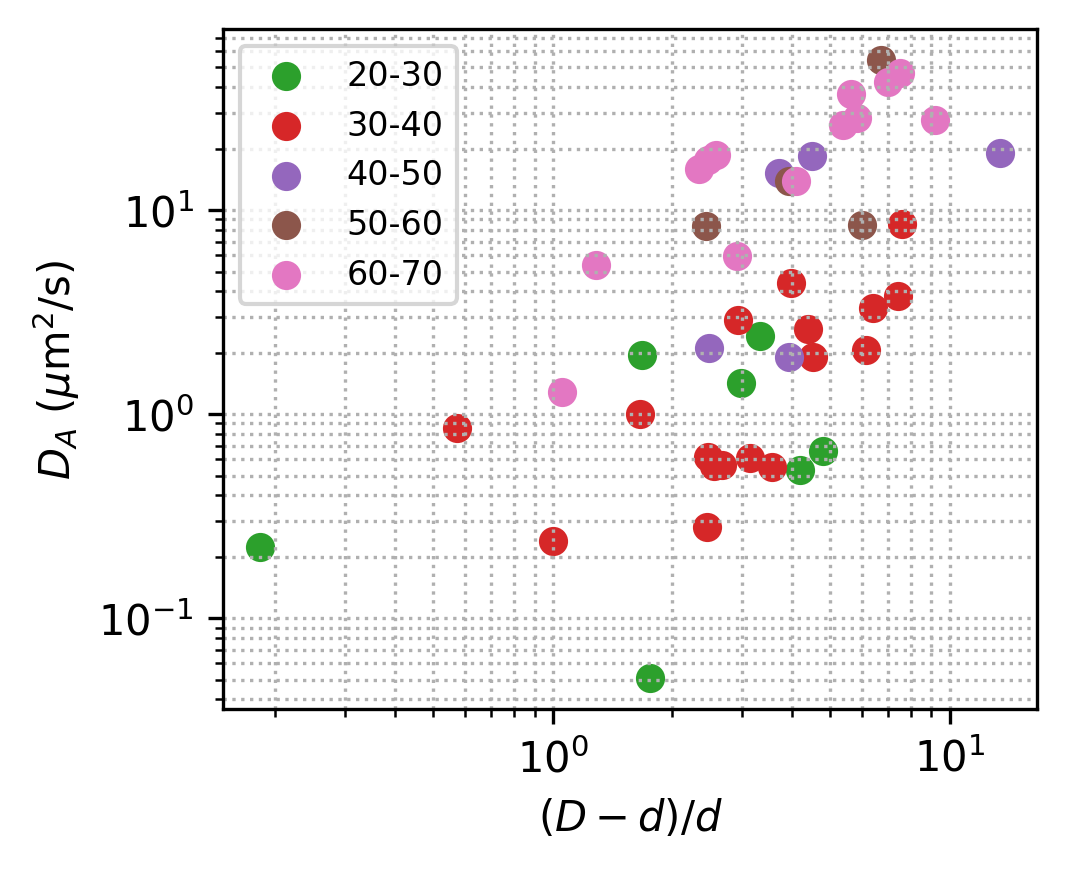

In [151]:
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)&(log["DE#"]>24)]
dd1 = de_data(log1)
ax = dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log")
log2 = log.loc[log["DE#"]<23]
ax.legend(loc="upper left", fontsize=8)
# ax.scatter(log2["(D-d)/d"], log2["DA_fit"], color=bestcolor(1), marker="^", fc=(0,0,0,0))
# ax.set_xlim([0, 10])
# ax.set_ylim([0, 60])

### 5.1 Limit cases

An intuitive limit case to test is $D\to \infty$. Practically, we can study the diffusion of oil droplets near a flat glass surface, agitated by active bacterial bath. Such unconfined motion will likely give a superdiffusive-diffusive type of MSD, and can be fitted using Wu and Libchaber's model for a diffusivity $D_A$. Such $D_A$, according to the current trend, should be the upper bound of the corresponding $D_A$'s confined in curved spaces. 

<font color="blue">An experiment of oil droplets near a flat glass surface is needed!</font>

### 5.2 Concentration dependence

From the $D_A$ vs. $(D-d)/d$ plot, we can see a pronounced concentration dependence of $D_A$: low concentration points are below the high concentration points! What is the exact nature of this dependence? Let's choose a small range of $(D-d)/d$, and plot $D_A$ as a function of OD.

(0.0, 30.0)

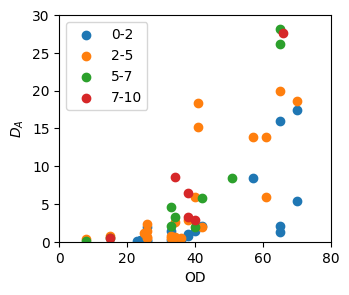

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=100)
d_bins = np.linspace(0, 10, 5)
binsize = d_bins[1] - d_bins[0]
for start in d_bins[:-1]:
    end = start + binsize
    sublog = log1.loc[(log["(D-d)/d"]>=start)&(log["(D-d)/d"]<end)]
    ax.scatter(sublog.OD, sublog.DA_fit, label="{0:d}-{1:d}".format(int(start), int(end)))
ax.legend()
ax.set_xlabel("OD")
ax.set_ylabel("$D_A$")
ax.set_xlim([0, 80])
ax.set_ylim([0, 30])
# ax.loglog()

## 6 Integrate data from literature

There are a few earlier works trying to measure the active diffusivity (or effective diffusivity). In Wu 2000, they fit the 2-D MSD with
$$
\langle\Delta\vec{r}^2(t)\rangle = 4Dt[1-\exp(-t/t_C)]
$$

In Maggi 2014, they fit 1-D MSD in the unconstrained direction $x$ with
$$
\langle\Delta x^2(t)\rangle = 2D_Tt + 2D_A[t-\tau(1-e^{-t/\tau})].
$$
In the $t\ll\tau$ limit, $1-e^{-t/\tau}\approx t/\tau - t^2/2\tau^2$, so that
$$
\langle\Delta x^2(t)\rangle = 2D_Tt + 2D_A[t-\tau(t/\tau - t^2/2\tau^2)] = 2D_Tt + \frac{D_A}{\tau}t^2
$$

In the diffusive regime, where $t\gg\tau$, the first expression simplifies to
$$
\langle\Delta\vec{r}^2(t)\rangle = 4Dt,
$$
while the second expression simplifies to
$$
\langle\Delta x^2(t)\rangle = 2(D_T+D_A)t.
$$

Note that the prefactor difference comes from the 2-D and 1-D difference. Then we realize that $D_{\text{eff}}$ is equivalent to $D_A+D_T$. If $D_T\ll D_A$, which is usually the case for particles larger than 10 $\mu$m, $D_{\text{eff}}$ is equivalent to $D_A$.

**Aside: diffusivity of 10 $\mu$m particle**

According to Stokes-Einstein relation, the diffusivity of a 10 $\mu$m particle in water is 
$$
D = \frac{k_BT}{6\pi\eta R} = \frac{1.38\times 10^{-23} \times 300}{6\pi \times 0.001 \times 5 \times 10^{-6}} = 0.04\,\mu\text{m}^2/\text{s}
$$

In [24]:
1.38e-23 * 300 / (6*np.pi*0.001*0.5e-5) * 1e12

0.04392676429336311

while the active diffusivity $D_A$ is typically greater than 0.1 $\mu$m$^2$/s. Therefor,e $D_A\gg D_T$ is true for most scenarios we are concerned.

### 6.1 Literature list

1. Wu, Xiao-Lun, and Albert Libchaber. “Particle Diffusion in a Quasi-Two-Dimensional Bacterial Bath.” Physical Review Letters 84, no. 13 (March 27, 2000): 3017–20. https://doi.org/10.1103/PhysRevLett.84.3017.
2. Miño, Gastón, Thomas E. Mallouk, Thierry Darnige, Mauricio Hoyos, Jeremi Dauchet, Jocelyn Dunstan, Rodrigo Soto, Yang Wang, Annie Rousselet, and Eric Clement. “Enhanced Diffusion Due to Active Swimmers at a Solid Surface.” Physical Review Letters 106, no. 4 (January 25, 2011): 048102. https://doi.org/10.1103/PhysRevLett.106.048102.
3. Kasyap, T. V., Donald L. Koch, and Mingming Wu. “Hydrodynamic Tracer Diffusion in Suspensions of Swimming Bacteria.” Physics of Fluids 26, no. 8 (August 2014): 081901. https://doi.org/10.1063/1.4891570.
4. Patteson, Alison E., Arvind Gopinath, Prashant K. Purohit, and Paulo E. Arratia. “Particle Diffusion in Active Fluids Is Non-Monotonic in Size.” Soft Matter 12, no. 8 (2016): 2365–72. https://doi.org/10.1039/C5SM02800K.
5. Lagarde, Antoine, Noémie Dagès, Takahiro Nemoto, Vincent Démery, Denis Bartolo, and Thomas Gibaud. “Colloidal Transport in Bacteria Suspensions: From Bacteria Collision to Anomalous and Enhanced Diffusion.” Soft Matter 16, no. 32 (August 19, 2020): 7503–12. https://doi.org/10.1039/D0SM00309C.
6. Maggi, Claudio, Matteo Paoluzzi, Nicola Pellicciotta, Alessia Lepore, Luca Angelani, and Roberto Di Leonardo. “Generalized Energy Equipartition in Harmonic Oscillators Driven by Active Baths.” Physical Review Letters 113, no. 23 (December 3, 2014): 238303. https://doi.org/10.1103/PhysRevLett.113.238303.

### 6.2 Diffusivity of particles in bacterial suspensions (literature)

The diffusivity of passive particles, which reflects the effective temperature of an active bath, has been studied extensively. Many factors have been varied to elucidate the nature of active noise, e.g. OD, particle size, particle density, as well as boundary conditions. Here, we summarize the $D_{\text{eff}}$ data from literature to so we can make more detailed comparison with our data. 

In [50]:
D_data = pd.read_excel(io=r"..\Data\diffusivity_literature.ods")
D_data.head()

,Bacterial concentration,OD,Tracer size,Curvature radius,Effective diffusivity,Thermal diffusivity,D_T/D_eff,Experimental system,Tracer material,Deff/OD*Tracersize,Reference,Comment
0,3000000000,3.750,10.0,0,10.0,0.043949,0.004395,Free-standing film,PS,26.666667,Wu 2000,NaN
1,6700000000,8.375,10.0,0,15.0,0.043949,0.002930,Free-standing film,PS,17.910448,Wu 2000,NaN
2,13400000000,16.750,10.0,0,35.0,0.043949,0.001256,Free-standing film,PS,20.895522,Wu 2000,NaN
3,26000000000,32.500,10.0,0,65.0,0.043949,0.000676,Free-standing film,PS,20,Wu 2000,NaN
4,53500000000,66.875,10.0,0,100.0,0.043949,0.000439,Free-standing film,PS,14.953271,Wu 2000,NaN


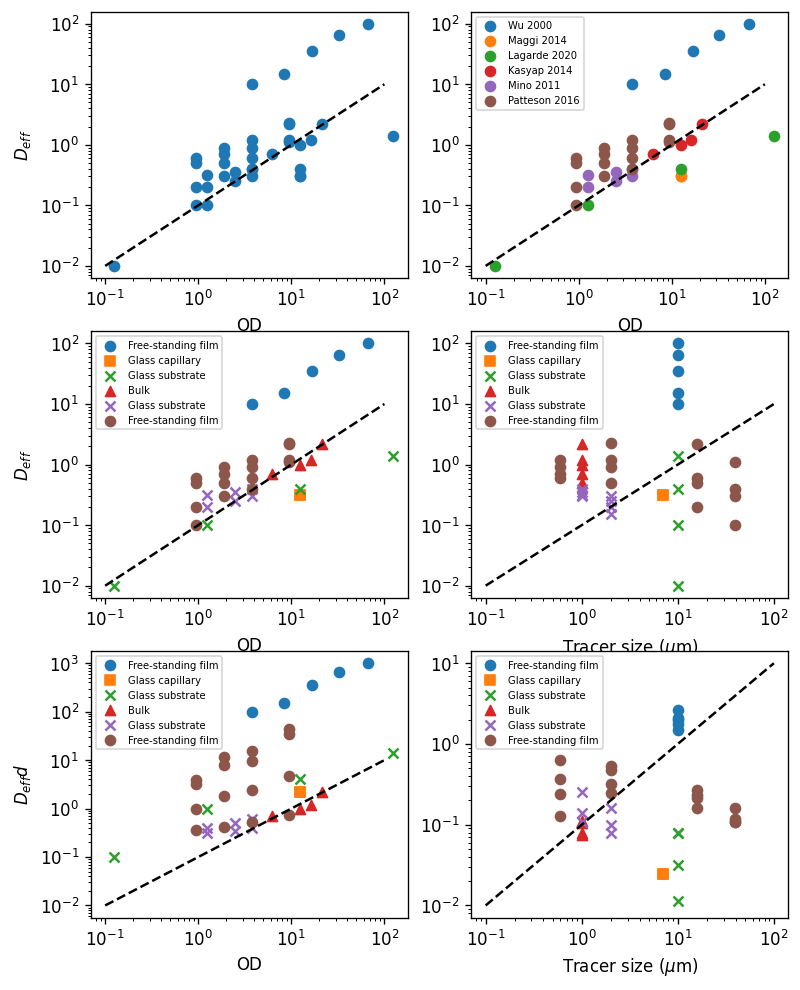

In [89]:
fig = plt.figure(figsize=(7.5, 10), dpi=120)
ax = fig.add_subplot(321)
ax.scatter(D_data.OD, D_data["Effective diffusivity"])
ax.loglog()
ax.set_xlabel("OD")
ax.set_ylabel(r"$D_{eff}$")
ax.plot([.1, 100], [.01, 10], ls="--", color="black")

# discern data from different works
ax1 = fig.add_subplot(322)
for num, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num)
    subdata = D_data.loc[D_data["Reference"]==ref]
    ax1.scatter(subdata.OD, subdata["Effective diffusivity"], label=ref, color=color)
ax1.loglog()
ax1.set_xlabel("OD")
ax1.plot([.1, 100], [.01, 10], ls="--", color="black")
ax1.legend(fontsize=6)

# discern data of different boundary condition
ax2 = fig.add_subplot(323)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax2.scatter(subdata.OD, subdata1["Effective diffusivity"], label=es, color=color, marker=marker)
ax2.loglog()
ax2.set_xlabel("OD")
ax2.set_ylabel(r"$D_{eff}$")
ax2.plot([.1, 100], [.01, 10], ls="--", color="black")
ax2.legend(fontsize=6)

# plot as a function of particle size
ax3 = fig.add_subplot(324)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax3.scatter(subdata["Tracer size"], subdata1["Effective diffusivity"], label=es, color=color, marker=marker)
ax3.loglog()
ax3.set_xlabel("Tracer size ($\mu$m)")
ax3.plot([.1, 100], [.01, 10], ls="--", color="black")
ax3.legend(fontsize=6)

# Rescale D_eff by timing tracer size, plot vs. OD
ax4 = fig.add_subplot(325)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax4.scatter(subdata.OD, subdata1["Effective diffusivity"]*subdata1["Tracer size"], label=es, color=color, marker=marker)
ax4.loglog()
ax4.set_xlabel("OD")
ax4.set_ylabel(r"$D_{eff}d$")
ax4.plot([.1, 100], [.01, 10], ls="--", color="black")
ax4.legend(fontsize=6)

# Rescale D_eff by timing tracer size, plot vs. tracer size
ax5 = fig.add_subplot(326)
es_to_marker = {}
marker_list = ["o", "s", "x", "^"]
for num, es in enumerate(D_data["Experimental system"].drop_duplicates()):
    es_to_marker[es] = marker_list[num] 
for num1, ref in enumerate(D_data["Reference"].drop_duplicates()):
    color = bestcolor(num1)
    subdata = D_data.loc[D_data["Reference"]==ref]
    for es in subdata["Experimental system"].drop_duplicates():
        marker = es_to_marker[es]
        subdata1 = subdata.loc[subdata["Experimental system"]==es]
        ax5.scatter(subdata["Tracer size"], subdata1["Effective diffusivity"]/subdata1["OD"], label=es, color=color, marker=marker)
ax5.loglog()
ax5.set_xlabel("Tracer size ($\mu$m)")
ax5.plot([.1, 100], [.01, 10], ls="--", color="black")
ax5.legend(fontsize=6)

## 7 Pendulum-like at high bacterial concentration?

At high bacterial concentration, collective motion takes place. The inner droplet agitated by collectively moving bacteria exhibits a pendulum-like motion, which is qualitatively different from a noise-driven motion. Such pendulum-like motion is characterized by **high probability of finding the droplet at high potential positions**, as well as a **non-diffusive position autocorrelation**. Here, we analyze these two properties of the inner droplet trajectories and see if the two characteristics mentioned above really exists in our system. 

In [179]:
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
n = 176
traj = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(n)).fillna(method="bfill")
log_item = log.loc[log["DE#"]==n]
MPP = float(log_item.MPP)
FPS = float(log_item.FPS)

corr_time = 13.0
sigma = 2.9


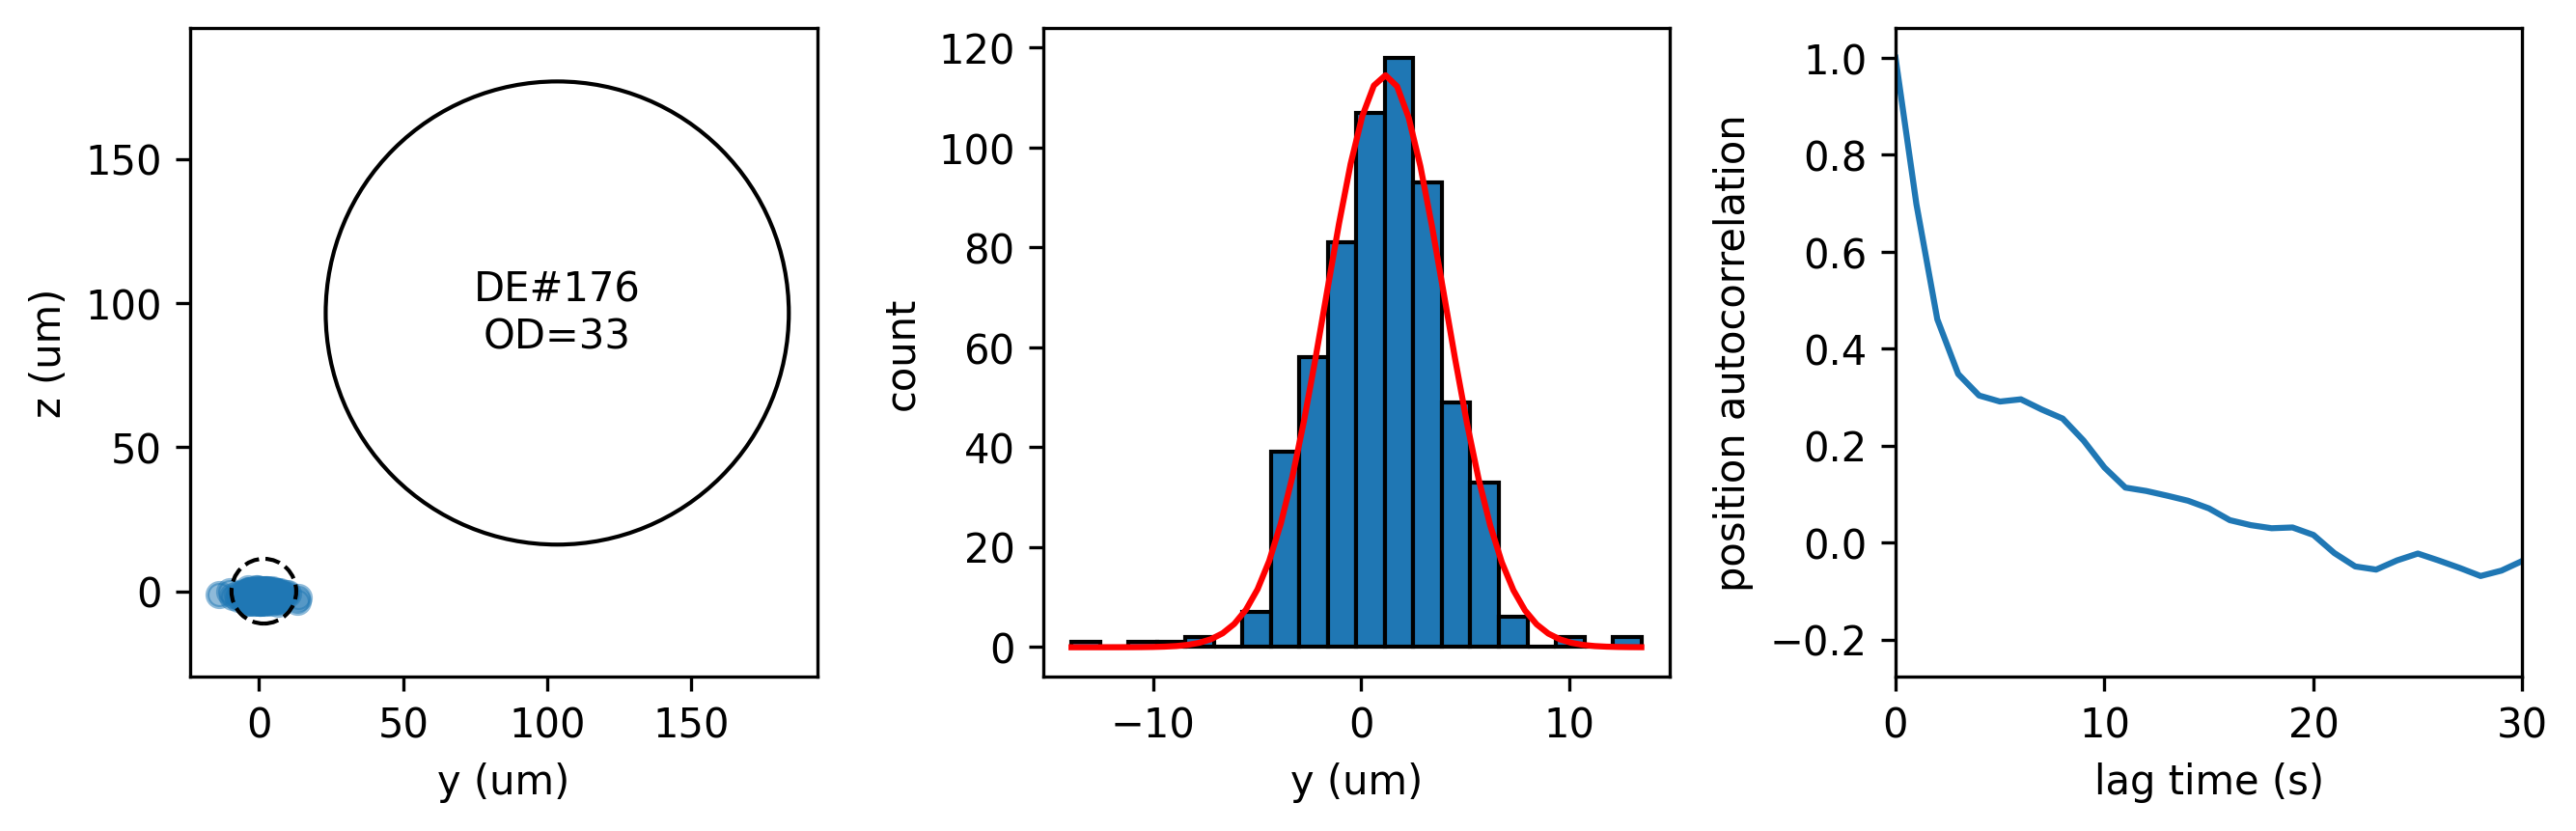

In [180]:
fig = plt.figure(figsize=(9, 3), dpi=300)
ax = fig.add_subplot(131)
ax.scatter(traj.y*MPP, traj.x*MPP, alpha=0.5)
elli = Ellipse((log_item.y0*log_item.MPP, log_item.x0*MPP), log_item.D, log_item.D, facecolor=(0,0,0,0), edgecolor="black")
elli_inner = Ellipse((traj.y.iloc[0]*MPP, traj.x.iloc[0]*MPP), log_item.d, log_item.d, facecolor=(0,0,0,0), edgecolor="black", ls="--")
ax.add_patch(elli)
ax.add_patch(elli_inner)
ax.axis("equal")
ax.set_xlabel("y (um)")
ax.set_ylabel("z (um)")

ax.annotate("DE#{0:02d}\nOD={1:d}".format(n, int(log_item.OD)), (log_item.y0*log_item.MPP, log_item.x0*MPP), 
            horizontalalignment="center", verticalalignment="center")

# Position probability distribution
hist, bin_edges = np.histogram(traj.y.dropna()*MPP, bins=20)
ax2 = fig.add_subplot(132, sketch_params={"scale": 1, "length": 10, "randomness": 1})
ax2.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax2.set_ylabel("count")
ax2.set_xlabel("y (um)")

## Fit a Gaussian to the position distribution
x = np.linspace(bin_edges[0], bin_edges[-1])
popt, pcov = curve_fit(gauss1, (bin_edges[:-1]+bin_edges[1:])/2, hist, 
                       p0=[hist.mean(), bin_edges.mean(), bin_edges[-1]-bin_edges[0], 0])
ax2.plot(x, gauss1(x, *popt), color="red")

# Position autocorrelation
corr = autocorr1d(traj.y)
lagt = 1 / FPS * traj.frame[:len(corr)]
ax3 = fig.add_subplot(133)
ax3.plot(lagt, corr)
ax3.set_xlabel("lag time (s)")
ax3.set_ylabel("position autocorrelation")
ax3.set_xlim([0, 30])

plt.tight_layout()

print("corr_time = {:.1f}".format(lagt[find_zero(corr-1e-1)]))
print("sigma = {:.1f}".format(abs(popt[2])))


In [85]:
def find_zero(x):
    tmp = x > 0
    inds = np.where(tmp==False)
    return inds[0][0]

(0.0, 20.0)

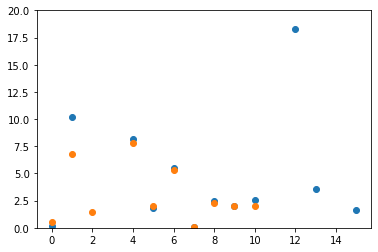

In [192]:
tmp_data = pd.read_excel(r"..\Data\structured_log_DE.ods", sheet_name="tmp")
plt.scatter(tmp_data.index, tmp_data.t2_new*tmp_data.DA_new)
plt.scatter(tmp_data.index, tmp_data.position_dist_sigma**2)

plt.ylim([0, 20])

In [148]:
tmp = corr > 0
inds = np.where(tmp==False)

In [154]:
lagt

0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
       ...  
295    295.0
296    296.0
297    297.0
298    298.0
299    299.0
Name: frame, Length: 300, dtype: float64

In [54]:
xn = x - np.nanmean(x)

In [56]:
np.correlate(xn, xn, mode="same")

array([nan, nan, nan, ..., nan, nan, nan])

Text(0, 0.5, 'angle (rad)')

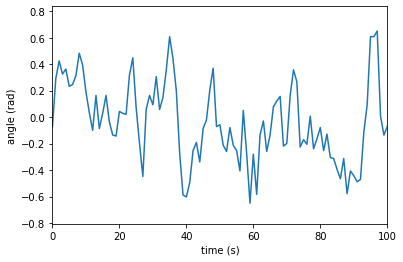

In [232]:
plt.plot(np.arctan((traj.y - float(log_item.y0))/float(log_item["D-d"])))
plt.xlim([0, 100])
plt.xlabel("time (s)")
plt.ylabel("angle (rad)")

(0.0, 50.0)

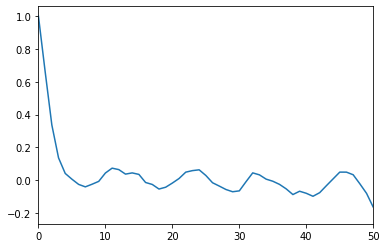

In [231]:
angle = np.arctan((traj.y - float(log_item.y0))/float(log_item["D-d"]))
corr = autocorr1d(angle)
plt.plot(corr)
plt.xlim([0, 50])

### 7.1 Hypothesis: constant speed circular motion
![](../images/2022/06/circular-motion.png)
$$
x = r\cos\omega t\\
y = r\sin\omega t\\
$$

If we look at the $y$-projection of the trajectory in one period:

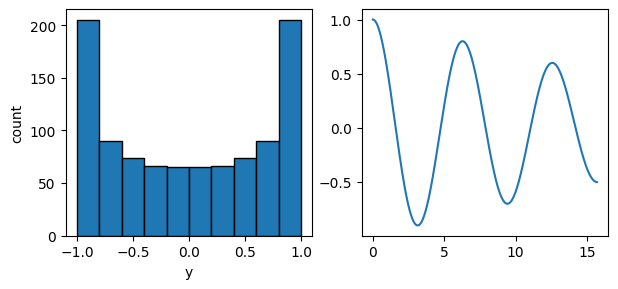

In [191]:
w = 1
r = 1
t = np.linspace(0, 10*np.pi/w, 1000)
y = r * np.sin(w*t)

hist, bin_edges = np.histogram(y)
fig= plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(121)
ax.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax.set_xlabel("y")
ax.set_ylabel("count")

ax2 = fig.add_subplot(122)
corr = autocorr1d(y)
ax2.plot(t[:len(corr)], corr)

This circular motion has a very extreme bimodal position distribution. Actually, we saw this circular motion in the $xy$-plane very early on in experiment, and I made the best 3-D trajectory visualization out of that experiment. 

![rvref](../images/outer-ref-demo.gif)

The corresponding position distribution:

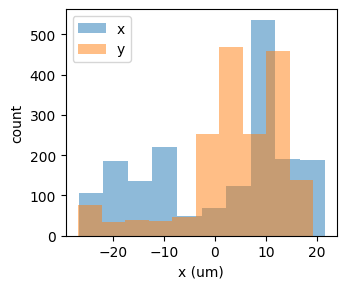

In [209]:
traj = pd.read_csv(r"..\Data\traj\01.csv")
MPP = 0.1
xhist, xbin_edges = np.histogram((traj.x-518)*MPP)
yhist, ybin_edges = np.histogram((traj.y-514)*MPP)

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
ax.bar((xbin_edges[:-1]+xbin_edges[1:])/2, xhist, width=xbin_edges[1]-xbin_edges[0],  alpha=0.5, label="x")
ax.bar((ybin_edges[:-1]+ybin_edges[1:])/2, yhist, width=ybin_edges[1]-ybin_edges[0],  alpha=0.5, label="y")
ax.set_xlabel("x (um)")
ax.set_ylabel("count")
ax.legend()

## 9 Small displacement approximation validation

The spring model assumes that the displacement of inner droplet is small compared to the outer droplet size, so that the restoring force is approximately proportional to the displacement in $y$. As we have estimated before, when the displacement goes beyond $r/2$ from equilibrium position, this approximation gets inaccurate. In practice, we want all the trajectory we analyze stay mostly in this range. Therefore, we compute the standard deviation y-displacement $\sigma_y$, and set a criterion $3\sigma_y < (R-r)$ to determine if we use the data in further analysis.

In [74]:
data_folder = r"..\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
c_list = []
for num, i in log.iterrows():
    traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i["DE#"])))
    c = 3 * traj.y.std() * i.MPP / (i.D - i.d) * 2
    c_list.append(c)

In [75]:
log1 = log.assign(c=c_list)

In [76]:
log1.to_csv("tmpc.csv")

## 10 Plot all the MSD together, rescale with $t_2$ and $D_A$ 

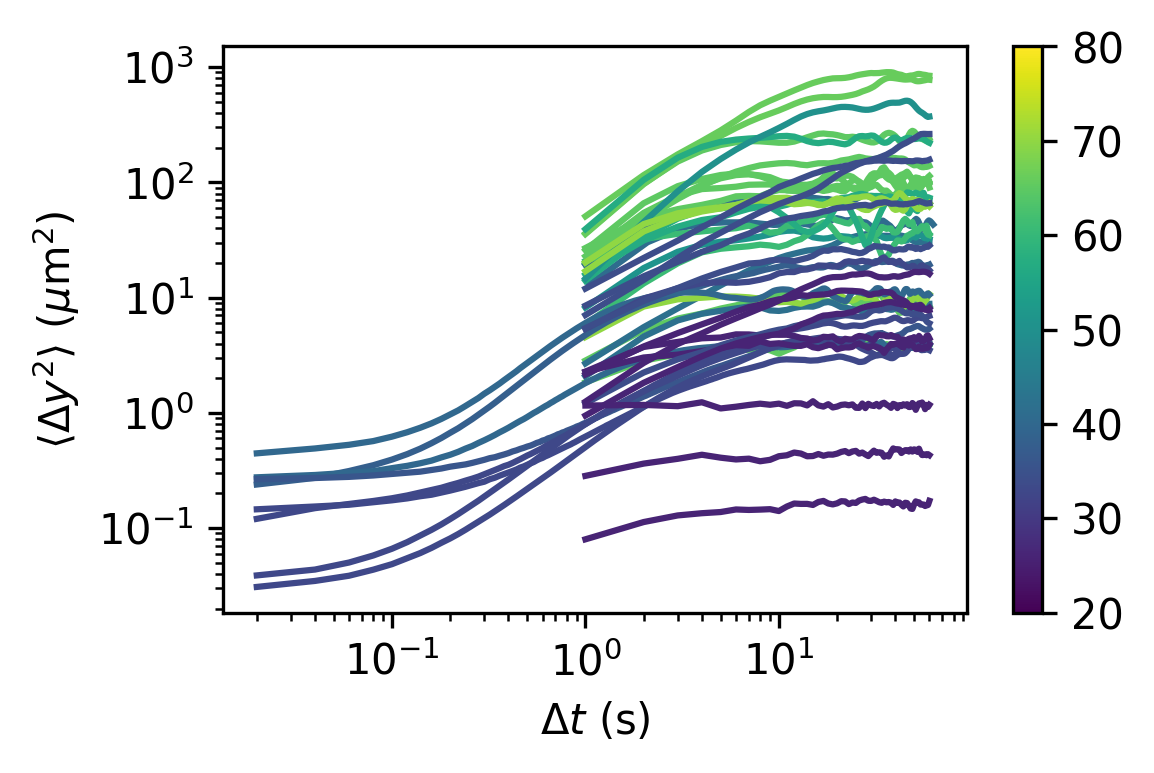

In [27]:
traj, msd = {}, {}
plt.figure(figsize=(4, 2.5), dpi=300)
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
for num, i in log1.iterrows():
    nDE = int(i["DE#"])
    if nDE == 172 or nDE == 161:
        continue
    traj[nDE] = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(nDE)).fillna(method="ffill")
    msd[nDE] = tp.msd(traj[nDE], mpp=i.MPP, fps=i.FPS, max_lagtime=3000).dropna()
    plt.plot(msd[nDE].lagt, msd[nDE]["<y^2>"], color=viridis(norm(i.OD)), label=nDE)
plt.loglog()
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("$\langle \Delta y^2 \\rangle$ ($\mu$m$^2$)")
sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm)

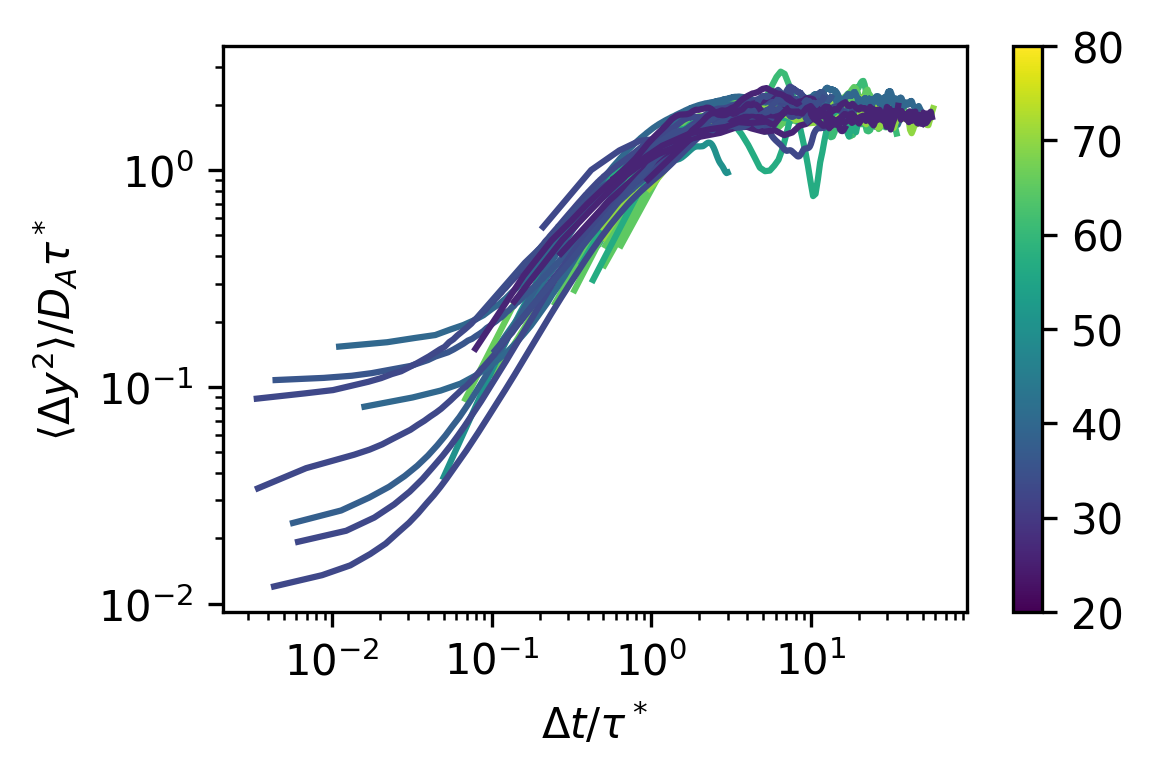

In [28]:
log2 = log1.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
plt.figure(figsize=(4, 2.5), dpi=300)
for num, i in log2.iterrows():
    nDE = int(i["DE#"])
    if nDE == 172 or nDE == 161:
        continue
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    plt.plot(msd[nDE].lagt/t2, msd[nDE]["<y^2>"]/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd[nDE]) != 0:
#         plt.annotate(nDE, 
#                      [msd[nDE].lagt.iloc[-1]/t2, msd[nDE]["<y^2>"].iloc[-1]/DA/t2],
#                      xycoords="data")
plt.loglog()
plt.xlabel("$\Delta t/\\tau^*$")
plt.ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm)

In [164]:
from matplotlib import cm, colors

## 11 Influence of mean velocity

In [38]:
log1 = log.dropna(subset=["mean velocity (1s)"])

In [42]:
log1 = log1.drop(labels=133)

Text(0, 0.5, 'mean velocity ($\\mu$m/s)')

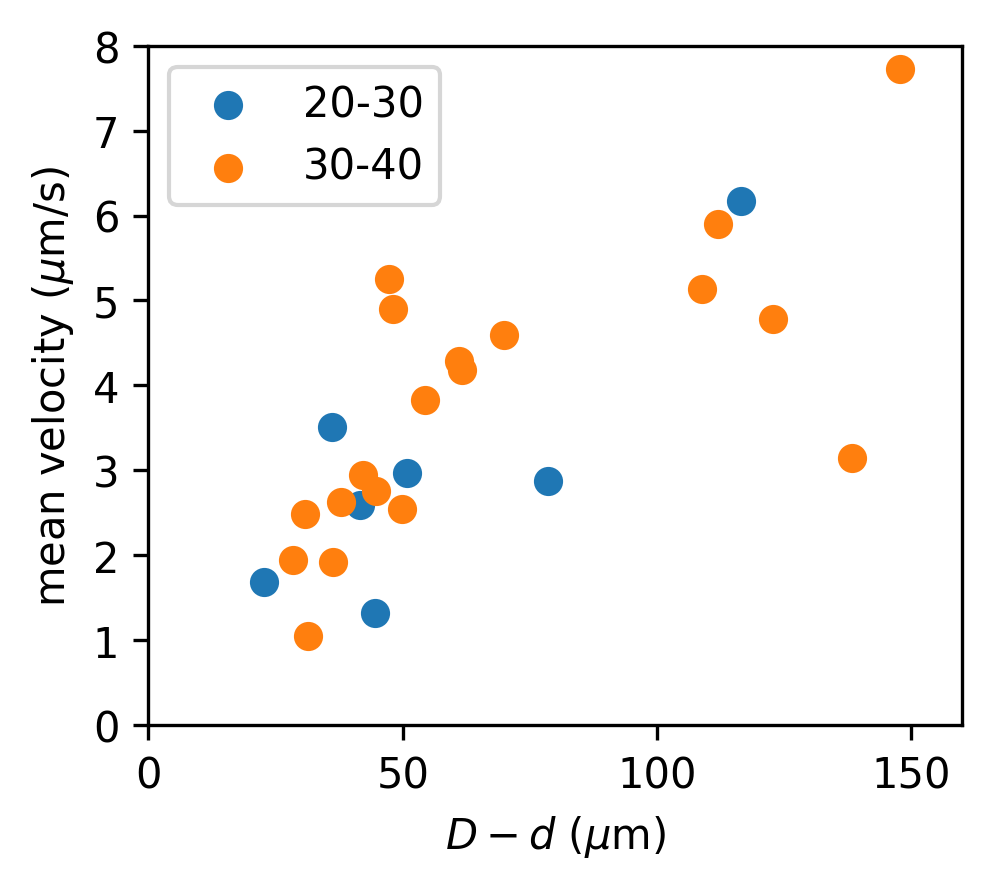

In [45]:
plt.figure(figsize=(3.5, 3), dpi=300)
log2 = log1.loc[log1.OD <= 30]
log3 = log1.loc[log1.OD > 30]
plt.scatter(log2["D-d"], log2["mean velocity (1s)"], label="20-30")
plt.scatter(log3["D-d"], log3["mean velocity (1s)"], label="30-40")
plt.legend()
plt.xlim([0, 160])
plt.ylim([0, 8])
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("mean velocity ($\mu$m/s)")

Text(0, 0.5, 'mean velocity ($\\mu$m/s)')

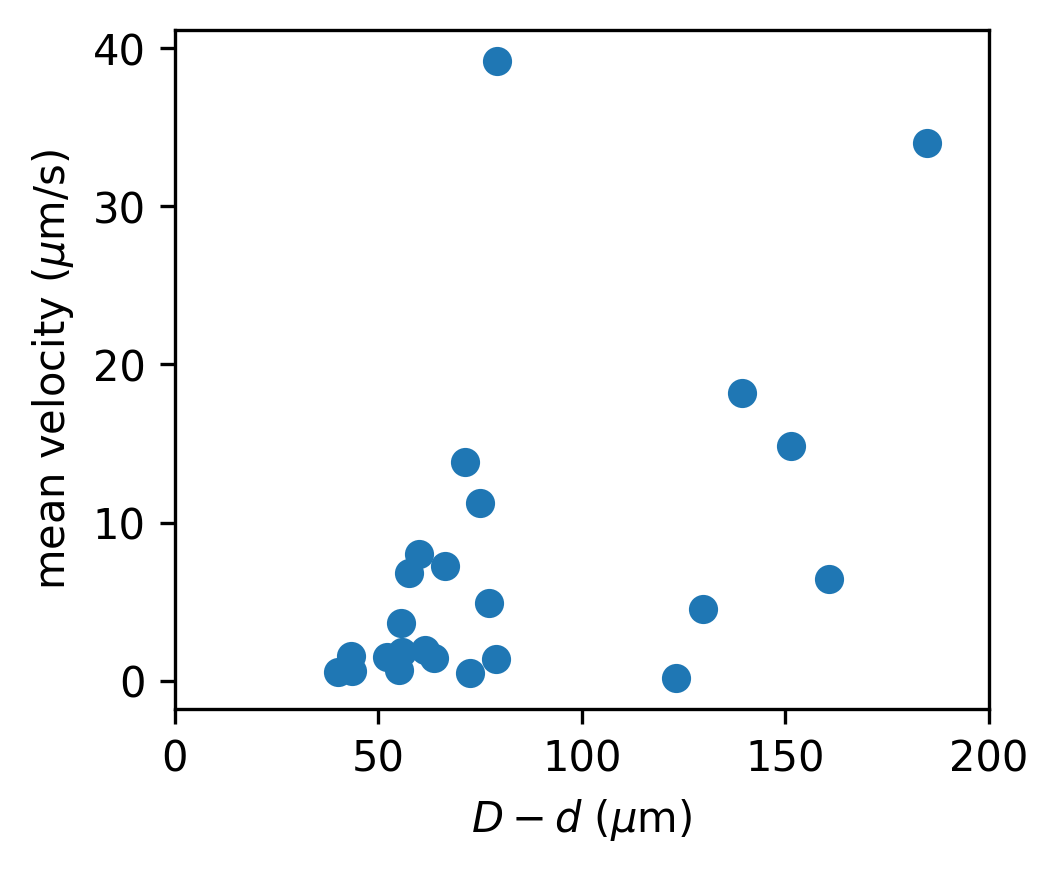

In [33]:
plt.figure(figsize=(3.5, 3), dpi=300)
plt.scatter(log1["D"], log1["DA_fit"]*log1["mean velocity (1s)"]**1)
plt.xlim([0, 200])
# plt.ylim([0, 8])
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("mean velocity ($\mu$m/s)")

### To be discussed
1. 1-D projection MSD
2. Tracer size dependence (inner droplet)
3. Curvature dependence and collective motion 